# Libs utilizadas

In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt

# Modelos de machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Pré-processamento e balanceamento
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Avaliação de modelos
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Utilitários
import joblib

# Metricas utilizadas
- Para avaliar os modelos de classificação, vamos utilizar a matriz de confusão
- Sendo:
    - 0: Não saiu da empresa
    - 1: Saiu da empresa

|               | **Predito: 0** | **Predito: 1** |
|---------------|----------------|----------------|
| **Real: 0**   | TN (Verdadeiro Negativo) | FP (Falso Positivo)  |
| **Real: 1**   | FN (Falso Negativo)      | TP (Verdadeiro Positivo) |

- Acurácia = (TP + TN) / (TP + TN + FP + FN)
- Precisão = TP / (TP + FP)
- Recall = TP / (TP + FN)
- F1-Score = 2 × (Precisão × Recall) / (Precisão + Recall)

Em attrition, FN são mais caros que FP, porque um FP só gera uma falsa preocupação, mas um FN pode significar perder um talento valioso sem aviso.
- Foco: Maximizar TP e Reduzir FN
- Identificar o maior número possível de funcionários que realmente vão sair (TP).
- Não  deixar passar funcionários que estão prestes a sair (FN).
- Para isso focaremos nas seguintes métricas:
    - **Recall**: (Sensibilidade / True Positive Rate) → Métrica principal
    - **F1-Score**: Equilíbrio entre precisão e recall
    - **Precision**:(Precisão) → Secundária

# Modelo baseline
- Modelo para servir de baseline, usa todas as features

In [2]:
# dados_model_baseline = pd.read_csv('data/dados_para_modelo_baseline.csv')
dados_model_baseline = pd.read_parquet('./data/dados_para_modelo_baseline.parquet')

In [3]:
X_b = dados_model_baseline.drop(columns=["Attrition"])
y_b = dados_model_baseline['Attrition']

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42, stratify=y_b)

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_b, y_train_b)
y_pred_b = model.predict(X_test_b)

In [4]:
y_proba_b = model.predict_proba(X_test_b)[:, 1]
threshold = 0.3
y_pred_custom = (y_proba_b >= threshold).astype(int)

In [6]:
print('Modelo Baseline')
print(f'Acurácia: {round(accuracy_score(y_test_b, y_pred_custom),2)}')
print(f'Precisão: {round(precision_score(y_test_b, y_pred_custom, zero_division=0),2)}')
print(f'Recall: {round(recall_score(y_test_b, y_pred_custom, zero_division=0),2)}')
print(f'F1-Score: {round(f1_score(y_test_b, y_pred_custom, zero_division=0),2)}')

Modelo Baseline
Acurácia: 0.82
Precisão: 0.23
Recall: 0.01
F1-Score: 0.01


In [7]:
cm = confusion_matrix(y_test_b, y_pred_custom)
cm

array([[153300,    598],
       [ 32835,    176]], dtype=int64)

# Modelo com features tratadas

### Carregando dados

In [8]:
X_test = pd.read_parquet('./data/processed/X_test.parquet')
y_test = pd.read_parquet('./data/processed/y_test.parquet').values.ravel()

### Carregando modelos

In [9]:
#sem rebalanceamento
dt_model = joblib.load('modelos/decision_tree.pkl')
rf_model = joblib.load('modelos/forest.pkl')
lr_model = joblib.load('modelos/logistic_regression.pkl')
svm_model = joblib.load('modelos/svm.pkl')
xgb_model = joblib.load('modelos/xgboost.pkl')

#com rebalanceamento
rf_model_r = joblib.load('modelos/forest_r.pkl')
lr_model_r = joblib.load('modelos/logistic_regression_r.pkl')
svm_model_r = joblib.load('modelos/svm_r.pkl')
xgb_model_r = joblib.load('modelos/xgboost_r.pkl')

In [10]:
modelos_results = {"decision_tree": dt_model,
                   "forest": rf_model,
                   "logistic_regression": lr_model,
                   "svm": svm_model,
                   "xgboost": xgb_model,
                   "forest_r": rf_model_r,
                   "logistic_regression_r": lr_model_r,
                   "svm_r": svm_model_r,
                   "xgboost_r": xgb_model_r,
                  }

### Função para avaliar modelo

In [11]:
def avaliar_modelos_classificacao(modelos, X_test, y_test):
    """ 
        Recebe um dicionario com nome do modelo e o modelo treinado, X_test e Y_test.
        Plota as matrizes de confusão.
        Gera um dataset com as métricas.
    """
    
    resultados = []

    for nome, modelo in modelos.items():
        y_pred = modelo.predict(X_test)

        # Print da matriz de confusão
        cm = confusion_matrix(y_test, y_pred)
        print(f"\n{nome} - Matriz de Confusão:")
        print(cm)

        resultados.append({
            'Modelo': nome,
            'Acurácia': accuracy_score(y_test, y_pred),
            'Precisão': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred, zero_division=0),
            'F1-Score': f1_score(y_test, y_pred, zero_division=0),
        })

    return pd.DataFrame(resultados).sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

In [12]:
print("""
| TN | FP |
| FN | TP |
""")


| TN | FP |
| FN | TP |



## Roda os testes

In [19]:
avaliar_modelos_classificacao(modelos_results, X_test, y_test)


decision_tree - Matriz de Confusão:
[[145418   8480]
 [ 30040   2971]]

forest - Matriz de Confusão:
[[153895      3]
 [ 33010      1]]

logistic_regression - Matriz de Confusão:
[[89054 64844]
 [12217 20794]]

svm - Matriz de Confusão:
[[153898      0]
 [ 33011      0]]

xgboost - Matriz de Confusão:
[[153613    285]
 [ 32773    238]]

forest_r - Matriz de Confusão:
[[125616  28282]
 [ 21763  11248]]

logistic_regression_r - Matriz de Confusão:
[[89657 64241]
 [12352 20659]]

svm_r - Matriz de Confusão:
[[89337 64561]
 [12253 20758]]

xgboost_r - Matriz de Confusão:
[[153649    249]
 [ 32796    215]]


,Modelo,Acurácia,Precisão,Recall,F1-Score
0,svm_r,0.589030,0.243299,0.628821,0.350849
1,logistic_regression,0.587708,0.242813,0.629911,0.350513
2,logistic_regression_r,0.590212,0.243333,0.625822,0.350417
3,forest_r,0.732249,0.284543,0.340735,0.310114
4,decision_tree,0.793910,0.259453,0.090000,0.133642
5,xgboost,0.823133,0.455067,0.007210,0.014195
6,xgboost_r,0.823203,0.463362,0.006513,0.012845
7,forest,0.823374,0.250000,0.000030,0.000061
8,svm,0.823385,0.000000,0.000000,0.000000


## Avaliação resultado
- svm_r e logistic_regression apresentaram melhor recall e F1-score. Pode ser um modelo promissor para o problema;
- Vale a pena ajustar os thresholds do modelo

## Codigo para testar varios Thresholds

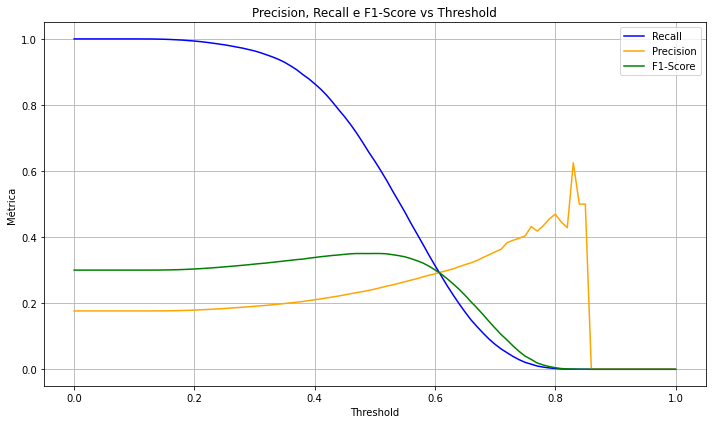

In [33]:
model = modelos_results["logistic_regression"]
y_proba = model.predict_proba(X_test)[:, 1]

# Intervalo de thresholds para testar
thresholds = np.arange(0.0, 1.01, 0.01)

recalls = []
precisions = []
f1_scores = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    r = recall_score(y_test, y_pred_t, zero_division=0)
    p = precision_score(y_test, y_pred_t, zero_division=0)
    f1 = f1_score(y_test, y_pred_t)
    
    recalls.append(r)
    precisions.append(p)
    f1_scores.append(f1)

# Plotar métricas
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, label='Recall', color='blue')
plt.plot(thresholds, precisions, label='Precision', color='orange')
plt.plot(thresholds, f1_scores, label='F1-Score', color='green')
plt.xlabel('Threshold')
plt.ylabel('Métrica')
plt.title('Precision, Recall e F1-Score vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Avaliação dos Thresholds

### Thresholds = 0.11

In [34]:
y_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.11
y_pred_cust = (y_proba >= threshold).astype(int)

print(f'Acurácia: {accuracy_score(y_test, y_pred_cust,)}')
print(f'Precisão: {precision_score(y_test, y_pred_cust, zero_division=0)}')
print(f'Recall: {recall_score(y_test, y_pred_cust, zero_division=0)}')
print(f'F1-Score: {f1_score(y_test, y_pred_cust, zero_division=0)}')
confusion_matrix(y_test, y_pred_cust)

Acurácia: 0.17665815985319058
Precisão: 0.17661599704650155
Recall: 0.9999394141346823
F1-Score: 0.3002073594412209


array([[    10, 153888],
       [     2,  33009]], dtype=int64)

### Thresholds = 0.42

In [35]:
y_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.42
y_pred_cust = (y_proba >= threshold).astype(int)

print(f'Acurácia: {accuracy_score(y_test, y_pred_cust,)}')
print(f'Precisão: {precision_score(y_test, y_pred_cust, zero_division=0)}')
print(f'Recall: {recall_score(y_test, y_pred_cust, zero_division=0)}')
print(f'F1-Score: {f1_score(y_test, y_pred_cust, zero_division=0)}')
cm = confusion_matrix(y_test, y_pred_cust)
print(cm)
print((cm/cm.sum())*100)

Acurácia: 0.4380955438207898
Precisão: 0.2159524786216907
Recall: 0.8292690315349429
F1-Score: 0.34266937881395715
[[54509 99389]
 [ 5636 27375]]
[[29.16338967 53.1750745 ]
 [ 3.01537112 14.64616471]]


# Conclusão
- O modelo escolhido foi a Regressão Logística com threshold de 0.42.
- Ao alterar o thresholds molhora o recall, reduzindo os casos de FN, porem piora precisão e F1-score.
- O Threshold de 0.42 prioriza o Recall em relação as outras métricas.

# Avalição do modelo
- Entendemos que para a seleção do modelo, decisões da empresa devem ser levadas em conta. Por exemplo, a baixa precisão pode gera alertas desnecessários, se o custo disso for baixo, não é um problema.

|Critério|Avaliação|
|---------------|----------------|
|Encontra quem vai sair?|✅ Sim (Recall alto: 82%)|
|Erra muitos falsos alertas?|⚠️ Sim (Precisão baixa: 21%)|
|É confiável para acionar ações?|⚠️ Pode gerar muitos alertas falsos|
|Está alinhado com o objetivo do negócio?|✅ Sim, se o foco é não deixar talentos saírem sem aviso|